In [1]:
import os
import sys
sys.path.append(f'{os.environ["HOME"]}/Projects/planckClusters/catalogs')
from load_catalogs import load_PSZcatalog
from model import beta_model, integ_beta_model, inv_beta_model
from utilities import parallel_process
from astropy.table import Table, Column
import numpy as np

/home/boada/Projects/swiftXRT/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def correct_fluxes(name, outpath):

    # if there aren't detections, don't bother doing anything.
    if os.path.isfile(f'{outpath}/{name}/{name}_vtp.detect'):
        detects = Table.read(f'{outpath}/{name}/{name}_vtp.detect', hdu=1)
    else:
        return

    # get the MCMC fits:
    if os.path.isfile(f'{outpath}/{name}/{name}_mcmcfits.txt'):
        mcmcfit = Table.read(f'{outpath}/{name}/{name}_mcmcfits.txt',
                             format='ascii',
                             header_start=0)
    
    # get the spectral fluxes
    if os.path.isfile(f'{outpath}/{name}/spec_files/{name}_xspec.results'):
        try:
            spec_info = Table.read(f'{outpath}/{name}/spec_files/{name}_xspec.results',
                             format='ascii',
                             header_start=2)
        except ValueError:
            spec_info = Table.read(f'{outpath}/{name}/spec_files/{name}_xspec.results',
                             format='ascii',
                             header_start=0)

    # add new columns
    cols = ['FLUX_corr', 'LUM_corr', 'CORR']
    for col in cols:
        try:
            spec_info.add_column(Column(data=np.zeros(len(spec_info)), name=col, dtype='<f8'))
        except ValueError:
            pass
    try:
        spec_info.add_column(Column(data=[name.replace('_', ' ')] * len(spec_info), name='FIELD'))
    except ValueError:
        pass
    spec_info['FIELD'] = name.replace('_', ' ')

    if len(spec_info) < 1:
        spec_info.write(f'{outpath}/{name}/spec_files/{name}_xspec.results', 
                        format='ascii.commented_header', overwrite=True)
        return
    
    
    # now we have to loop through the detections
    for i, (j, flux, lum) in enumerate(spec_info[['INDEX', 'FLUX', 'LUM']]):

        # Break out the values we are gonna need about the beta model
        So = mcmcfit['So_50'][mcmcfit['ID'] == j].data[0]
        rc = mcmcfit['rc_50'][mcmcfit['ID'] == j].data[0] # arcmin
        beta = mcmcfit['beta_50'][mcmcfit['ID'] == j].data[0]
        bkg = mcmcfit['bg_50'][mcmcfit['ID'] == j].data[0] # cnts/s/arcmin2
        
        # get all the different radii that we will need
        # background
        radius_bkg = inv_beta_model(So, rc, beta, bkg)
        
        # integrate the beta model 0 -> bkg
        zero_bkg = integ_beta_model(radius_bkg, rc=rc, beta=beta)  # cnts
            
        # integrate the beta model bkg -> 5*rc
        bkg_5rc = integ_beta_model(radius_bkg, rc=5*rc, beta=beta)  # cnts
        
        spec_info[i]['CORR'] = bkg_5rc / zero_bkg
        spec_info[i]['FLUX_corr'] = flux * (1 + bkg_5rc / zero_bkg)
        spec_info[i]['LUM_corr'] = lum * (1 + bkg_5rc / zero_bkg)
        
        spec_info.write(f'{outpath}/{name}/spec_files/{name}_xspec.results', 
                        format='ascii.commented_header', overwrite=True)
        
#         print(So, rc, beta, bkg)
#         print(radius_bkg, rc)
#         print(zero_bkg, bkg_5rc)
        
    return bkg_5rc / zero_bkg
        
        

In [3]:
# get file data
data = load_PSZcatalog()
data = data.sort_values('NAME')

outpath = './data_full_new'

arr = [{'name':n.replace(' ', '_'), 'outpath':outpath} for n in data['NAME']]
results = parallel_process(arr, correct_fluxes, use_kwargs=True, n_jobs=2)


KeyError: INDEX
InconsistentTableError: 
ERROR: Unable to guess table format with the guesses listed below:
Reader:Ecsv fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 strict_names: True
Reader:FixedWidthTwoLine fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 strict_names: True
Reader:RST fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 strict_names: True
Reader:FastBasic fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 strict_names: True
Reader:Basic fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 strict_names: True
Reader:FastRdb fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 strict_names: True
Reader:Rdb fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 strict_names: True
Reader:FastTab fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 0 strict_names: True
Reader:Tab fast_reader: {'enable': True} fill_values:

KeyError: INDEX
KeyError: INDEX



In [ ]:
outpath ='./data_full_new'
name = 'PSZ2_G075.08+19.83'
name = 'PSZ2_G283.91+73.87'
# name = 'PSZ1_G121.35-42.47'
# name = 'PSZ2_G057.80+88.00'

correct_fluxes(name, outpath)

In [4]:
results = [x for x in results if isinstance(x, float)]

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [6]:
results = np.array(results)

<IPython.core.display.Javascript object>


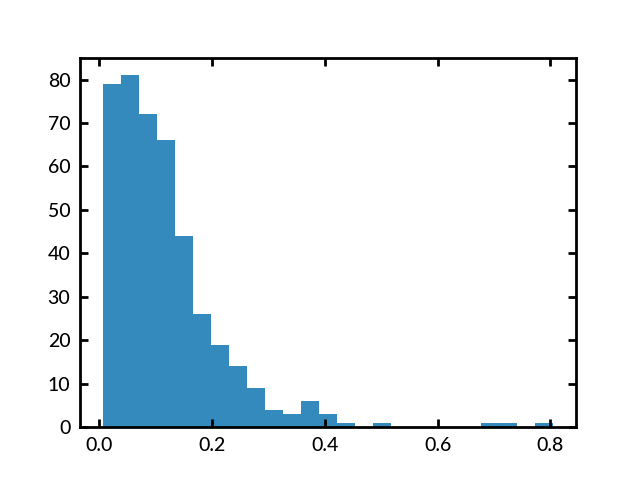

(array([79., 81., 72., 66., 44., 26., 19., 14.,  9.,  4.,  3.,  6.,  3.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.]),
 array([0.00646438, 0.03841788, 0.07037139, 0.10232489, 0.1342784 ,
        0.1662319 , 0.1981854 , 0.23013891, 0.26209241, 0.29404592,
        0.32599942, 0.35795292, 0.38990643, 0.42185993, 0.45381344,
        0.48576694, 0.51772044, 0.54967395, 0.58162745, 0.61358096,
        0.64553446, 0.67748796, 0.70944147, 0.74139497, 0.77334848,
        0.80530198]),
 <a list of 25 Patch objects>)

In [8]:
plt.hist(results, bins=25)

In [9]:
np.nanmedian(results)

0.09486232727401865

In [10]:
np.nanmean(results)

0.11640187045325605

In [11]:
len(results)

431

In [ ]:
results